<a href="https://colab.research.google.com/github/wendystep2221/Reconocimiento-de-emociones-a-travez-de-video/blob/master/Pre_procesamiento_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de emociones Humanas a travez de video

El proyecto tendrá como objetivo la clasificación de las emociones. Este análisis se hará con la base de datos de [RAVDESS](https://zenodo.org/record/1188976#.XsyEAmhKhPY). La cual tiene dos tipos de archivos:

Audio: Habla y canto
Video: Habla y canto
Cada uno de estos tiene varios identificadores, los cuales son los siguientes:

*   Modalidad (01 = full-AV, 02 = video-only, 03 = audio-only).

*   Canal de audio (01 = speech, 02 = song).
*   Emoción (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Intensidad Emocional (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*   Declaración (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetición (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


A través de esto, se busca realizar una clasificación de la emoción que encontramos en los archivos. Lo cual será desarrollado por medio de redes neuronales convolucionadas y redes recurrentes.

Se tomará como referencia los siguientes papers:
https://dl.acm.org/doi/10.1145/3318299.3318321

http://www.ijmlc.org/vol9/759-L0179.pdf

https://dl.acm.org/doi/pdf/10.1145/2818346.2830596

https://dl.acm.org/doi/pdf/10.1145/2993148.2997632




Para el reconocimiento de expreciones faciales en video se usará resdes convolucionadas y sobre ellas redes recurrentes.

# Conectar con drive para leer los datos desde allí 


In [1]:
from google.colab import drive #Conexión con Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerias en uso

In [2]:
import cv2     # Para capturar videos
import os
import math   
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

import tensorflow as tf


Using TensorFlow backend.


In [3]:
#Ubicación de los datos 
PATH = '/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video'


In [4]:
dic  =  {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}

Se determinó a través del camino de la carpeta los archivos que encontramos en el objeto ``dir_list``



In [5]:
dir_list = os.listdir(PATH)
dir_list.sort()
#dir_list

Se extraerán solo los archivos de Video, es decir "*.mp4"
y se asignará en listas, la emoción, el modo y la dirección del archivo

**Modalidad**:
* 01= Video-Audio
* 02= Solo video

**Canal**
* 01= Habla
* 02= Canto

**Emoción**:
*  01=Neutral
*  02=Calmado
*  03=Feliz
*  04=Triste
*  05=Enojado
*  06=Asustado
*  07=Disgustado
*  08= Sorprendido

Estos fueron extraídos de la **1er, 2da y 3ra posición** respectivamente en el nombre del archivo:

In [ ]:
dir_list[4200]

'02-02-05-02-01-01-08.mp4'

In [ ]:
emocion = []
modo = []
canal= []
path = []
etiqueta=[]

for f in dir_list:
  if f.split('.')[1]=='mp4':
    part1 = f.split('.')[0].split('-')[2]
    part2 = f.split('.')[0].split('-')[1]
    part3 = f.split('.')[0].split('-')[0]
    etiq = f.split('.')[0]
    emocion.append(part1)
    canal.append(part2)
    modo.append(part3)
    etiqueta.append(etiq)
    path.append(PATH +'/' + f)
    



In [ ]:
data.head()

,path,etiqueta,modo,canal,emocion
0,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-01,01,01,01
1,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-02,01,01,01
2,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-03,01,01,01
3,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-04,01,01,01
4,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-05,01,01,01


In [ ]:
data=pd.DataFrame(list(zip(path,etiqueta,modo,canal, emocion)),columns=['path','etiqueta','modo','canal', 'emocion'])
data.head()
print('Total=',len(data))
len(data.loc[data.modo=='02'] )
print('Audio y video=',len(data.loc[data.modo=='01'] ))
print('Sólo video=',len(data.loc[data.modo=='02'] ))
print('canto=',len(data.loc[data.canal=='02'] ))
print('Habla=',len(data.loc[data.modo=='02'].loc[data.canal=='01'] ))

Total= 4456
Audio y video= 2228
Sólo video= 2228
canto= 1936
Habla= 1260


In [5]:
#data.to_csv(PATH+'datalist.csv')
data=pd.read_csv(PATH+'datalist.csv',header=0,names=['path','etiqueta','modo','canal', 'emocion'])

## Lista de ubicación, etiquetas y modo


In [ ]:
data['emocion']

0       1
1       1
2       1
3       1
4       1
       ..
4451    6
4452    6
4453    6
4454    6
4455    6
Name: emocion, Length: 4456, dtype: int64

En total se tienen 4456 archivos de video, de los cuales:

* 2228 contienen audio y 2228 solo vídeo.
* De los que contienen audio, 1260 son de habla.
* De los videos sin audio 1260 son de habla.

Por tanto concluimos que los vídeos sin audio y con audio son los mismos. 


Se puede notar que la cantidad de personas para cada uno de los tipos de emociones no es la misma, donde para la emoción neutral tenemos la mitad que para las emociones. Mientras que para las emociones de disgusto y sorprsa tenemos un poco más de la mitad que para las de calma, felicidad, tristeza, enojado y asustado. 


In [6]:
emocion = data['emocion'].tolist()
modo = data['modo'].tolist()
canal= data['canal'].tolist()
path = data['path'].tolist()
etiqueta= data['etiqueta'].tolist()


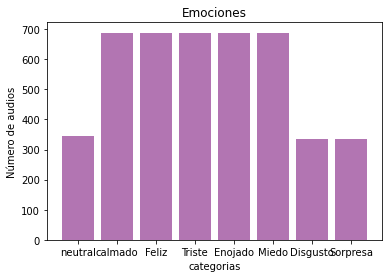

In [8]:

  
# Make a fake dataset:
height = pd.DataFrame(emocion).groupby(emocion).size()
bars = ('neutral','calmado','Feliz', 'Triste', 'Enojado','Miedo', 'Disgusto','Sorpresa')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Emociones')
plt.xlabel('categorias')
plt.ylabel('Número de audios')

# Create names on the x-axis
plt.xticks(y_pos, bars)


# Show graphic
plt.show()


# Pre-procesamiento del video

## descripción de los datos
Se tienen archivos de video en que 12 Actores y 12 Actrices profesionales, interpretan 6 emociones distintas, diciendo la misma oración en cada interpretación.

Los cuadros de video originales son de 1280*720 donde se enfoca el rostro de manera frontal del actor con un fondo blanco y la iluminación es igual para todos.

## Propuesta

Despues de consultar varios articulos, la propuesta de pre-procesamiento de video se llevará acabo de la siguiente manera:

1. Del video se extraerá una secuencia de imagenes
2. De cada imagen se identificará e rostro eliminando información no util, por ejemplo, el fondo, las orejas, cabello y cuello.
3. Se pone en escala de grises y se alinean los rostros
4. Se redimensiona las imagenes



## Extraer frames del video y guardar las imagenes


In [ ]:

video1 = cv2.VideoCapture(path[1])
frames = int(cv2.CAP_PROP_FRAME_COUNT) 
altura= int(cv2.CAP_PROP_FRAME_WIDTH)
ancho= int(cv2.CAP_PROP_FRAME_HEIGHT)

print('frames =', cv2.VideoCapture.get(video1, frames))
print('Altura frame =', cv2.VideoCapture.get(video1, altura))
print('Ancho frame =', cv2.VideoCapture.get(video1, ancho))


frames = 109.0
Altura frame = 1280.0
Ancho frame = 720.0


### Extraeremos el promedio de frames por video para establecer cuantos frames vamos a extraer de cada uno

Devido al tiempo de ejecución , se toma una muestra aleatoria de 600 videos y se extrae el numero de frames promedio para cada video, este da al rededor de 122 frames por video, adicional a ellos, la duración de los videos es de 4 segundos aproximadamente. Basandonos en 

In [ ]:
from random import sample 
sample=sample(path,600)


In [5]:
frames=int(cv2.CAP_PROP_FRAME_COUNT) 
fps=int(cv2.CAP_PROP_FPS)
nframes=0
nfps=0
item=0
for i in sample:
  video1 = cv2.VideoCapture(i)
  nframes += cv2.VideoCapture.get(video1, frames)
  nfps += cv2.VideoCapture.get(video1, fps)
  item+=1


NameError: ignored

In [ ]:
nframes/len(sample)

122.555

In [ ]:
nfps/len(sample)

29.970029970030343

De una muestra aleatoria de tamaño 600, obtuvimos un promedio de 122 frames por vídeo, Conservarlos todos podría significar un costo computacional muy grande, además cada vídeo tiene al rededor de 29 frames por segundo.


In [ ]:
len(path)

4456

## Escalar y convertir a grises

convertiremos los videos a escala de grises y reduciremos su resolución de 1280x720 a 256x144 y tambien reduciremos la cantidad de frames a la mitad, con esto, el video tendrá al rededor de 61 frames. en terminos de memoria, el video pasa de ocupar alproximadamente 3MB a 88KB.


Para esto se define la siguiente función:

In [7]:
scala=(256,144)
path_salida= PATH+'/newdata/'

In [8]:

def scala_y_gris(video_original,path_salida,nombre,scala):
  i=0
  cap = cv2.VideoCapture(video_original)
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(path_salida+nombre+'.avi',fourcc,24,scala,isColor=False)
  while True:
    ret, frame = cap.read()
    i+=1
    if ret == True:
      if i%2==0:
        b = cv2.resize(frame,scala,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        b= cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
        out.write(b)
    else:
        break
  cap.release()
  out.release()
  cv2.destroyAllWindows()
  return out


Con esta función se crea el nuevo conjunto de datos con os videos reducidos

In [ ]:
for i in range(len(path)):
  scala_y_gris(path[i],path_salida,etiqueta[i],scala)

## Extraer rostros y alinear
Una vez escalados los videos y reducidos vamos a itentar cortar el rostro decada uno y poner en un tensor la secuencia de rostros.

* Para extraer los rostros se usará un detector facial pre-entrenado ya existente "dlib"
* Luego se extraen las coordenadas del recuadro que contiene el rostro
* Se extrae la imagen que contiene sólo el rostro y se escala a un tamaño unico para asignarla a un tensor.


In [8]:
import cv2
import dlib
import numpy as np
from google.colab.patches import cv2_imshow


In [ ]:
path_salida

'/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video/newdata/'

In [ ]:
cap = cv2.VideoCapture(path_salida+etiqueta[2]+'.avi')
f, im = cap.read()
# Initialize dlib's face detector
detector = dlib.get_frontal_face_detector()
# Detecting faces in the grayscale image
faces = detector(im)
print(faces)


rectangles[[(93, 45) (165, 117)]]


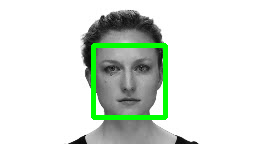

In [ ]:
# Creating a for loop in order to extract
# specific coordinates (x1,x2,y1,y2)
for face in faces:
  x1=face.left()
  y1=face.top()
  x2=face.right()
  y2=face.bottom()
# Drawing a rectangle around the face
  cv2.rectangle(im, (x1,y1), (x2,y2),(0,255,0),3)
cv2_imshow(im)

### Cortar rostros
Se corta el recuadro detectado por **dlib** y se redimensiona a 48x48 para obtener así una medida estandar en los rostros recortados

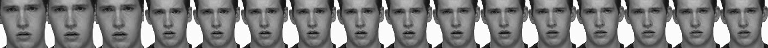

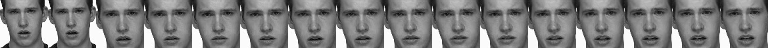

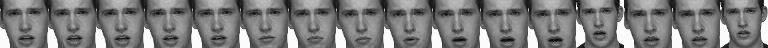

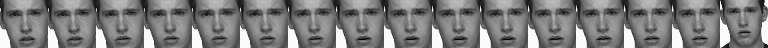

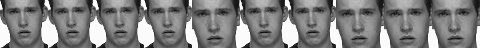

In [ ]:
cap = cv2.VideoCapture(path_salida+etiqueta[4000]+'.avi')
i=0
while True:
    f, im = cap.read() # f returns only True, False according to video access
    # (f, im) = video.read() # video 

    if f != True:
      cv2_imshow(numpy_horiz_concat)
      break
    detector = dlib.get_frontal_face_detector()
    faces = detector(im)
    #print(faces)
    
    for face in faces:
      x1=face.left()
      y1=face.top()
      x2=face.right()
      y2=face.bottom()#
      # Dibujar el rectangulo
      #cv2.rectangle(im, (x1,y1), (x2,y2),(0,255,0),3)

    sub_face = im[y1:y2, x1:x2]
    sub_face= cv2.resize(sub_face,(48,48),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
    #cv2_imshow(sub_face)
    im=sub_face
    if i==0:
      numpy_horiz_concat=im
    elif i%16 !=0:
      numpy_horiz_concat = np.concatenate((numpy_horiz_concat,im), axis=1)
    else:
      cv2_imshow(numpy_horiz_concat)
      numpy_horiz_concat=im
    i+=1

cap.release()
cv2.destroyAllWindows()


In [ ]:
i=26
i%1==0

True

In [9]:
scala=(256,144)
tamano=(48,48)
path_salida2= PATH+'/cropped_face/'

def recorte(video_original,path_salida,nombre,tamano):
  i=0
  cap = cv2.VideoCapture(video_original)
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(path_salida+nombre+'.avi',fourcc,24,tamano,isColor=False)
  while True:
    ret, frame = cap.read()
    i+=1
    if ret == True:
      if i%1==0:
        im= frame
        detector = dlib.get_frontal_face_detector()
        faces = detector(im)
        
        for face in faces:
          x1=face.left()
          y1=face.top()
          x2=face.right()
          y2=face.bottom()

        sub_face = im[y1:y2, x1:x2]
        sub_face= cv2.resize(sub_face,tamano,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        im=sub_face
        out.write(im)
    else:
      break
  cap.release()
  out.release()
  cv2.destroyAllWindows()
  return out

In [ ]:
recorte(path_salida+etiqueta[8]+'.avi',path_salida2,etiqueta[8],tamano)

<VideoWriter 0x7f594e2a3070>

In [ ]:
import time

start = time.time()

for i in range(1):
  recorte(path_salida+etiqueta[i]+'.avi',path_salida2,etiqueta[i],tamano)

end = time.time()
print(end-start)

17.868488788604736


In [10]:
scala=(256,144)
tamano=(48,48)
def scala_recorte_y_gris(video_original,path_salida,nombre,scala,tamano):
  i=0
  cap = cv2.VideoCapture(video_original)
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(path_salida+nombre+'.avi',fourcc,24,tamano,isColor=False)
  while True:
    ret, frame = cap.read()
    i+=1
    if ret == True:
      if i%1==0:
      #if i%2==0:
        b = cv2.resize(frame,scala,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        b= cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
        im= b
        detector = dlib.get_frontal_face_detector()
        faces = detector(im)
        
        for face in faces:
          x1=face.left()
          y1=face.top()
          x2=face.right()
          y2=face.bottom()

        sub_face = im[y1:y2, x1:x2]
        sub_face= cv2.resize(sub_face,tamano,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        im=sub_face
        out.write(im)
    else:
      break
  cap.release()
  out.release()
  cv2.destroyAllWindows()
  return out

In [ ]:
path_salida

'/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video/newdata/'

In [ ]:
for i in range(571,len(etiqueta)): # quedó en i=1336
  scala_recorte_y_gris(path_salida+etiqueta[i]+'.avi',path_salida2,etiqueta[i],scala,tamano)

## Por ahora trabajaremos con los datos speech
los videos deben dejarse de una cantidad exacta de frames

In [11]:
path_caras= PATH+'/cropped_face/'
dir_list = os.listdir(path_caras)
dir_list.sort()
#dir_list

In [ ]:
dir_list[1].split('.')[0].split('-')

['01', '01', '01', '01', '01', '01', '02']

In [12]:
emo = []
mod = []
can= []
pat = []
eti=[]

for f in dir_list:
  if f.split('.')[1]=='avi':
    part1 = f.split('.')[0].split('-')[2]
    part2 = f.split('.')[0].split('-')[1]
    part3 = f.split('.')[0].split('-')[0]
    etiq = f.split('.')[0]
    emo.append(part1)
    can.append(part2)
    mod.append(part3)
    eti.append(etiq)
    pat.append(path_caras +'/' + f)

In [13]:
data_caras=pd.DataFrame(list(zip(pat,eti,mod,can, emo)),columns=['pat','eti','mod','can', 'emo'])
data_caras.head()

,pat,eti,mod,can,emo
0,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-01,01,01,01
1,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-02,01,01,01
2,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-03,01,01,01
3,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-04,01,01,01
4,/content/drive/My Drive/Minería de datos/Proy...,01-01-01-01-01-01-05,01,01,01


4456

Tomemos los videos correspondientes a speech

In [60]:
data_caras[(data_caras['can']=='01')&(data_caras['mod']=='01')]
height =data_caras[data_caras['can']=='01'].groupby('emo').size()

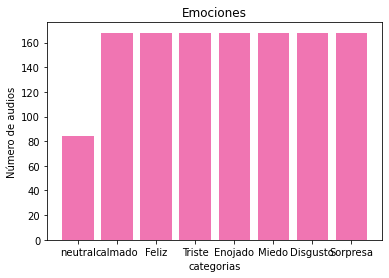

In [14]:
# Make a fake dataset:
height =data_caras[(data_caras['can']=='01')&(data_caras['mod']=='01')].groupby('emo').size()
bars = ('neutral','calmado','Feliz', 'Triste', 'Enojado','Miedo', 'Disgusto','Sorpresa')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color = (0.9,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Emociones')
plt.xlabel('categorias')
plt.ylabel('Número de audios')

# Create names on the x-axis
plt.xticks(y_pos, bars)


# Show graphic
plt.show()

los videos deben dejarse de una cantidad exacta de frames.

In [17]:
caras_spech= data_caras[(data_caras['can']=='01')&(data_caras['mod']=='01')].pat.tolist()
#caras_spech


Convertimos los vídeos a un tensor:
La siguiente función convierte los videos a un tensor de tamaño fijo, es decir antendrá del video un número especifico de frames para obtener al final tensores de igual tamaño, se mantendrán los n frames medios de cada video


In [15]:
def video_to_tensor(video,nframes):
  cap = cv2.VideoCapture(video)
  i=0
  frames = int(cv2.CAP_PROP_FRAME_COUNT) 
  n=cv2.VideoCapture.get(cap, frames) #número de frames en el video
  #Vamos a eliminar los frmaes sobrantes 
  delete=(n-nframes)
  r=[]
  while True:
    f, im = cap.read() # 
    if f != True:
      break
    if delete== 0. :
        im=tf.image.rgb_to_grayscale(im, name=None)
        if i==0:
          array=im
        else:
          array=tf.concat([array,im],2)
    
    
      
    elif delete==1: #me devuelve los  nframes del medio
        im=tf.image.rgb_to_grayscale(im, name=None)
        if i>=1 :
            if i==1:
              array=im
            else:
              array=tf.concat([array,im],2)
            r.append(i)
        
      
    elif (i>(delete-(np.floor(delete/2))) and i<= (n-(np.floor(delete/2)))): #me devuelve los  nframes del medio
        im=tf.image.rgb_to_grayscale(im, name=None)
        if i==((delete-(np.floor(delete/2)))+1):
          array=im
        else:
          array=tf.concat([array,im],2)
        r.append(i)
    i+=1

  cap.release()
  cv2.destroyAllWindows()
  return array

In [56]:
delete=1
np.floor(delete/2)

0.0

In [75]:
video_to_tensor(caras_spech[219],44) #44 frames de cada video

<tf.Tensor: shape=(48, 48, 44), dtype=uint8, numpy=
array([[[ 26,  17,  12, ...,  24,  27,  24],
        [ 53,  48,  45, ...,  40,  46,  55],
        [ 79,  76,  74, ...,  75,  81,  85],
        ...,
        [ 19,  20,  17, ...,  22,  19,  15],
        [ 13,  17,  17, ...,  18,  20,  23],
        [ 62,  55,  54, ...,  58,  97, 133]],

       [[ 24,  17,  17, ...,  29,  24,  31],
        [ 48,  40,  38, ...,  34,  43,  44],
        [ 75,  80,  79, ...,  80,  82,  87],
        ...,
        [ 19,  17,  16, ...,  18,  18,  15],
        [ 17,  18,  17, ...,  15,  12,  10],
        [ 40,  32,  31, ...,  72,  97, 119]],

       [[ 20,  17,  23, ...,  19,  19,  24],
        [ 39,  31,  34, ...,  33,  37,  47],
        [ 80,  80,  80, ...,  67,  80,  79],
        ...,
        [ 13,  10,  11, ...,  11,  13,  19],
        [ 18,  20,  18, ...,  17,  19,  18],
        [ 31,  25,  24, ..., 110, 152, 181]],

       ...,

       [[253, 253, 253, ..., 252, 253, 253],
        [255, 255, 255, ..., 255, 2

In [50]:
#import time
#start=time.time()
video_to_tensor(caras_spech[219],44).shape

#end=time.time()
#(end-start)

TensorShape([48, 48, 43])

Cómo el número minímo de frames será 44 se toma la decisión de mantener en cada video los 44 frames medios

In [162]:

a=video_to_tensor(pat[1],44)
c=tf.transpose(a)


In [294]:
tf.shape(c)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([44, 48, 48], dtype=int32)>

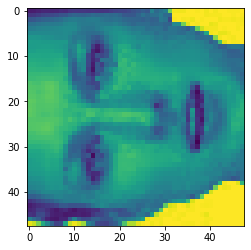

In [164]:
plt.imshow(c[21])

Se crea el conjunto de datos que tendrá los tensores/ videos y los labels que en este caso son las emociones:

In [35]:
lst=data_caras.loc[(data_caras['can']=='01')&(data_caras['mod']=='01'),['pat','emo']].values.tolist()

In [36]:
lst[1]

['/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video/cropped_face//01-01-01-01-01-01-02.avi',
 '01']

In [246]:
star=time.time()
arr=video_to_tensor(p[0],44),p[1]
(time.time()-star)*1260/60

1.5289885997772217

In [76]:
datos=[]
No_compatibles=[]
for p in lst:
  try:
    arr=np.asarray(video_to_tensor(p[0],44)),p[1]
    datos.append(arr)
  except:
    No_compatibles.append(p)


In [77]:
datos[218][0].shape

(48, 48, 44)

In [38]:
No_compatibles

[['/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video/cropped_face//01-01-02-02-01-02-15.avi',
  '02'],
 ['/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video/cropped_face//01-01-04-02-02-02-06.avi',
  '04']]

Ya está completo el pre-procesamiento, y se crea el conjunto de datos co sus etiquetas

In [81]:
x,y=zip(*datos)

In [79]:
s=list(x)


In [44]:
s[218].shape

(48, 48, 43)

In [84]:
x = np.asarray(x)
y = np.asarray(y)
x.shape, y.shape

((1258, 48, 48, 44), (1258,))

In [291]:
tf.shape([1])

<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>

# Conjunto de datos pre-procesado

In [85]:
import joblib

x_name = 'X_speech.joblib'
y_name = 'y_speech.joblib'
save_dir ='/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/Model_video'
savedx = joblib.dump(x, os.path.join(save_dir, x_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [86]:
X = joblib.load('/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/Model_video/X_speech.joblib')
y = joblib.load('/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/Model_video/y_speech.joblib')
y=y.astype(int)

# Datos de canto

En los datos de canto no existen las emociones de disgusto y sorpresa

In [16]:
data_caras[(data_caras['can']=='02')&(data_caras['mod']=='01')].groupby('emo').size()

emo
01     89
02    176
03    176
04    176
05    176
06    176
dtype: int64

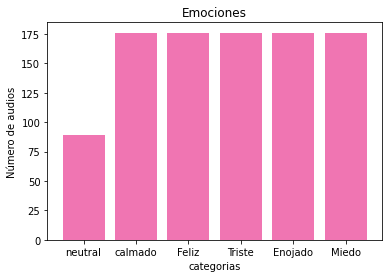

In [17]:
# Make a fake dataset:
height =data_caras[(data_caras['can']=='02')&(data_caras['mod']=='01')].groupby('emo').size()
bars = ('neutral','calmado','Feliz', 'Triste', 'Enojado','Miedo')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color = (0.9,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Emociones')
plt.xlabel('categorias')
plt.ylabel('Número de audios')

# Create names on the x-axis
plt.xticks(y_pos, bars)


# Show graphic
plt.show()

In [19]:
caras_song= data_caras[(data_caras['can']=='02')&(data_caras['mod']=='01')].pat.tolist()


In [30]:
len(lst_song)

969

In [29]:
lst_song=data_caras.loc[(data_caras['can']=='02')&(data_caras['mod']=='01'),['pat','emo']].values.tolist()

In [39]:
lst_song[1]
#np.array(video_to_tensor(lst_song[1][0],44))

['/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video/cropped_face//01-02-01-01-01-01-02.avi',
 '01']

In [40]:
datos_song=[]
No_compatibles_song=[]
i=0
for p in lst_song:
  try:
    arr=np.asarray(video_to_tensor(p[0],44)),p[1]
    datos_song.append(arr)
  except:
    No_compatibles_song.append(p)

In [41]:
No_compatibles_song

[['/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video/cropped_face//01-02-01-01-02-02-12 (1).avi',
  '01'],
 ['/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Video/cropped_face//01-02-02-01-01-01-24.avi',
  '02']]

In [42]:
x,y=zip(*datos_song)
x = np.asarray(x)
y = np.asarray(y)
x.shape, y.shape

((967, 48, 48, 44), (967,))

In [43]:
import joblib

x_name = 'X_song.joblib'
y_name = 'y_song.joblib'
save_dir ='/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/Model_video'
savedx = joblib.dump(x, os.path.join(save_dir, x_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [ ]:
X = joblib.load('/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/Model_video/X_speech.joblib')
y = joblib.load('/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/Model_video/y_speech.joblib')
y=y.astype(int)